# **Importing Libraries**

In [21]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import PIL.Image as Image 
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader
from torchvision import models,transforms 
import torchvision.models as models
import time
from sklearn.metrics import roc_curve, roc_auc_score

# **Device Checking**

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device) 

cuda


# **Creating Data Frame**

In [23]:
path = "/kaggle/input/csvfile/"

train_df = pd.read_csv(f"{path}Train.csv")
print(f'No.of.training_samples: {len(train_df)}')

# test_df = pd.read_csv(f'{path}test.csv')
# print(f'No.of.testing_samples: {len(test_df)}')


No.of.training_samples: 5750


In [24]:
train_df

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
5745,fa59221cf464_1,4
5746,fb696a8e055a_1,4
5747,fce93caa4758_1,4
5748,fdd534271f3d_1,4


# **Histogram Plotting**

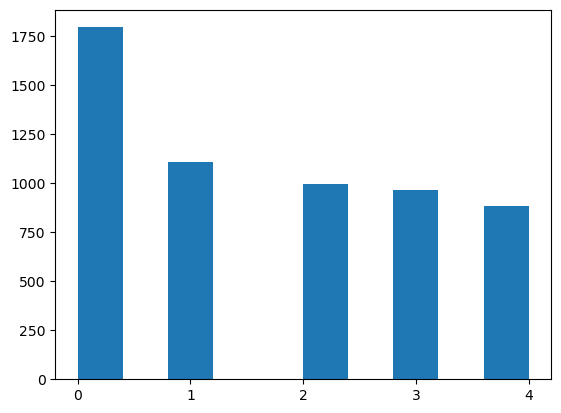

In [25]:
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 




# **Assigning Weights**

In [26]:
from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
 
print(class_weights)

tensor([0.6403, 1.0370, 1.1558, 1.1917, 1.2994], device='cuda:0')


# **Print Random Image**

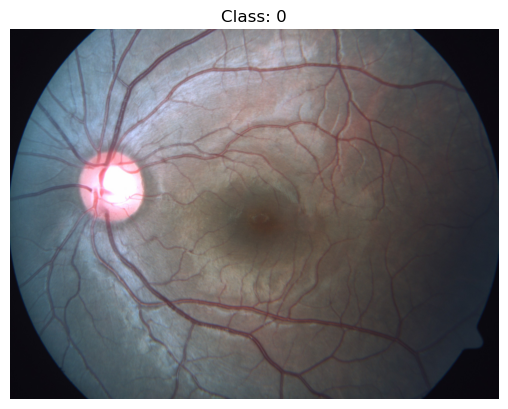

In [27]:
path='/kaggle/input/aptos-augmented/'
num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
sample_image = (f'{path}Train/Train/{train_df["id_code"][num]}.png')#Image file.
sample_image = Image.open(sample_image) 
plt.imshow(sample_image)
plt.axis('off')
plt.title(f'Class: {train_df["diagnosis"][num]}') #Class of the random image.
plt.show()

# **Creating Custom Dataset**

In [28]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.

# **Image Transform And Train, Valid Split**

In [29]:
from torchvision.transforms import RandomApply, GaussianBlur

# Define the augmentation transforms
zoom_scale = (0.3, 0.45)
gaussian_blur_kernel_size = 3

augmentation_transforms = transforms.Compose([
    transforms.RandomApply([transforms.RandomAffine(0, scale=zoom_scale)], p=0.5),
    transforms.RandomApply([GaussianBlur(kernel_size=gaussian_blur_kernel_size)], p=0.5)
])

# Define the image transformation pipeline
image_transform = transforms.Compose([
    transforms.Resize([384, 384]),
    augmentation_transforms,
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])#Transformations to apply to the image.

image_transform_Val = transforms.Compose([
    transforms.Resize([384, 384]),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
data_set = dataset(train_df,f'/kaggle/input/aptos-augmented/Train/Train')

train_set,valid_set = torch.utils.data.random_split(data_set,[5133,617],generator=torch.Generator().manual_seed(42))
train_set.dataset.image_transform = image_transform
valid_set.dataset.image_transform = image_transform_Val

# **Class Distribution**

In [30]:
# class_counts = [0] * 5  # Initialize the counts for each class

# for data in train_set:
#     label = data[1]  # Assuming the label is stored at the first position in each tuple
#     class_counts[label] += 1

# for class_idx, count in enumerate(class_counts):
#     print(f"Class {class_idx}: {count} samples")



In [31]:
# class_counts = [0] * 5  # Initialize the counts for each class

# for data in valid_set:
#     label = data[1]  # Assuming the label is stored at the first position in each tuple
#     class_counts[label] += 1

# for class_idx, count in enumerate(class_counts):
#     print(f"Class {class_idx}: {count} samples")

# **Dataloaders**

In [32]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True) 
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False) 

# **Model Initialization**

In [33]:
import torch
import timm
import torch.nn as nn

model = timm.create_model('deit3_small_patch16_384.fb_in1k', pretrained=True)


model.head = nn.Sequential(
    nn.LayerNorm(384, eps=1e-06, elementwise_affine=True),
    nn.Linear(384, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 5)
)
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

# **Shifiting it to CUDA/CPU**

In [34]:
model = model.to(device)

# **Train Function**

In [35]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
    
   
             
    
    avg_loss = running_loss/len(dataloader)
    train_accuracy = 100 * (correct / total)# Average loss for a single batch
    
    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss, train_accuracy

# **Validation Function**

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
def validate(dataloader, model, loss_fn):
    '''
    validate function calculates the average loss per batch, the accuracy of the model's predictions,
    and the macro F1 score.
    
    Args:
        dataloader: Iterator for the batches in the data_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns:
        Average loss per batch, accuracy on the validation set, and macro F1 score.
    '''
    
    model.eval()  # Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    probabilities = []
    true_labels = []
    predictions = []
    
    with torch.no_grad():  # No need to calculate the gradients.
        
        for x, y in dataloader:
            
            output = model(x.to(device))  # Model's output.
            loss = loss_fn(output, y.to(device)).item()  # Loss calculation.
            running_loss += loss
            
            total += y.size(0)
            batch_predictions = output.argmax(dim=1).cpu().detach()  # Predictions for the batch.
            correct += (batch_predictions == y.cpu().detach()).sum().item()
            
            predictions.extend(batch_predictions)  # Collect predictions for all batches
            true_labels.extend(y.cpu().numpy())
        
    true_labels = np.array(true_labels)
    avg_loss = running_loss / len(dataloader)
    valid_accuracy = 100 * (correct / total)
    
    precision = precision_score(true_labels, predictions, average='macro', zero_division=1)
    recall = recall_score(true_labels, predictions, average='macro')
    macro_f1 = f1_score(true_labels, predictions, average='macro')
    kappa_score = cohen_kappa_score(true_labels, predictions, weights='quadratic')
    print(f'\nValidation Loss per batch = {avg_loss:.6f}', end='\t')
    print(f'Accuracy on Validation set = {valid_accuracy:.6f}% [{correct}/{total}]')  # Prints the accuracy.
    print(f'Macro Precision Score: {precision:.6f}')
    print(f'Macro Recall Score: {recall:.6f}') 
    print(f'Macro F1 Score: {macro_f1:.6f}') 
    print(f'Quadratic Kappa Score: {kappa_score:.6f}')
    return avg_loss, valid_accuracy


# **Optimize Function**

In [37]:
def optimize(train_dataloader, valid_dataloader, model, loss_fn,loss_fn_Valid, optimizer, scheduler, nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.

    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.

    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    # Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []
    valid_loss_min = np.Inf
    train_accuracies = []
    valid_accuracies = []
    train_times = []
    patience=7


    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        start_time = time.time()
        
        train_loss,train_accuracy = train(train_dataloader, model, loss_fn, optimizer)  # Calls the train function.
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        end_time = time.time()
        
        valid_loss,valid_accuracy  = validate(valid_dataloader, model,loss_fn_Valid)  # Calls the validate function.
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        
        # Calculate training time in seconds
        epoch_time = end_time - start_time
        train_times.append(epoch_time)
        overall_train_time = sum(train_times)
      
        # Save the model if validation loss has decreased.
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), "/kaggle/working/deit3_small_patch16_384.fb_in1k.pt")
            valid_loss_min = valid_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Check if early stopping criteria is met
        if early_stop_counter >= patience:
            print(f"Early stopping! No improvement for {patience} epochs.")
            break
            
        # Learning rate scheduler step  
        scheduler.step()

    print('\nTraining has completed!')
    print(f'Training Time: {overall_train_time:.2f} seconds')

    return train_losses, train_accuracies, valid_losses, valid_accuracies

# **Loss Function,Optimzer, Regularizer, Scheduler**

In [38]:
loss_fn   = nn.CrossEntropyLoss()
loss_fn_Valid   = nn.CrossEntropyLoss()#CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.001, weight_decay=0.01, momentum=0.9) 

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=65, gamma=0.1)


In [39]:
# model.load_state_dict(torch.load('/kaggle/working/resnet34_Pipeline.pt'))

# **Training And Validation**

In [40]:
nb_epochs = 60
# Call the optimize function.
train_losses, train_accuracies, valid_losses, valid_accuracies = optimize(train_dataloader, valid_dataloader, model, loss_fn,loss_fn_Valid, optimizer, scheduler, nb_epochs)


Epoch 1/60
-------------------------------

Training Loss per batch = 0.927251	Accuracy on Training set = 60.919540% [3127/5133]

Validation Loss per batch = 0.551631	Accuracy on Validation set = 82.009724% [506/617]
Macro Precision Score: 0.801528
Macro Recall Score: 0.782365
Macro F1 Score: 0.787016
Quadratic Kappa Score: 0.883038
Validation loss decreased (inf --> 0.551631).  Saving model ...

Epoch 2/60
-------------------------------

Training Loss per batch = 0.525289	Accuracy on Training set = 79.777908% [4095/5133]

Validation Loss per batch = 0.605497	Accuracy on Validation set = 78.930308% [487/617]
Macro Precision Score: 0.765733
Macro Recall Score: 0.756299
Macro F1 Score: 0.745755
Quadratic Kappa Score: 0.849930

Epoch 3/60
-------------------------------

Training Loss per batch = 0.419339	Accuracy on Training set = 83.576856% [4290/5133]

Validation Loss per batch = 0.452317	Accuracy on Validation set = 83.792545% [517/617]
Macro Precision Score: 0.815118
Macro Recall S

# **Loading Model Weights**

In [41]:
model.load_state_dict(torch.load('/kaggle/working/deit3_small_patch16_384.fb_in1k.pt'))

<All keys matched successfully>

# **Training And Validation Accuracy Curve**

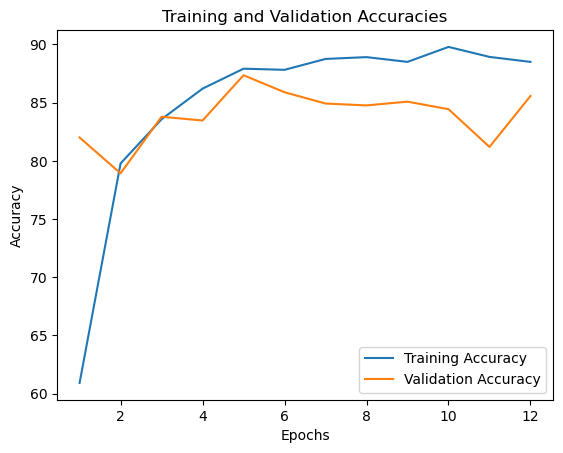

In [42]:

plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()



# **Training And Validation Loss Curve**

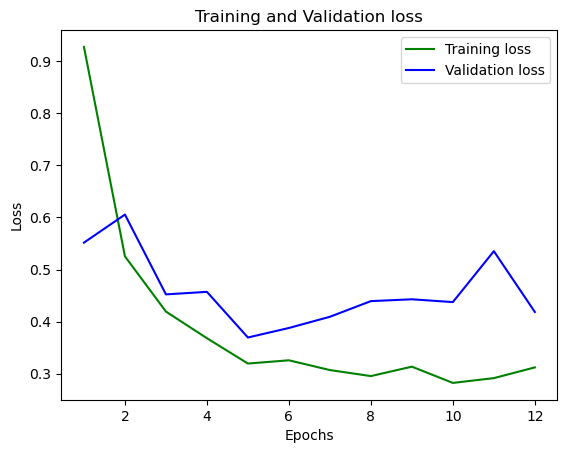

In [43]:
#Plot the graph of train_losses & valid_losses against nb_epochs.
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Testing Model**

In [44]:
# model.load_state_dict(torch.load('/kaggle/input/resnet34-pipeline-old-val-sample/resnet34_Pipeline_old_val_sample.pt'))

In [45]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['image'][index]
        image = Image.open(f'{self.data_path}/{image_id}.jpeg') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['level'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.

# **Dataframe For Test**

In [46]:
test_df = pd.read_csv('/kaggle/input/eyepacspreprocess/trainLabels.csv')
print(f'No.of.testing_samples: {len(test_df)}')

No.of.testing_samples: 35108


# **Image Transform**

In [47]:
image_transform = transforms.Compose([transforms.Resize([384,384]),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.3199, 0.2240, 0.1609],std=[0.3020, 0.2183, 0.1741])]) #Transformations to apply to the image.
test_set = dataset(test_df,'/kaggle/input/eyepacspreprocess/eyepacs_preprocess/eyepacs_preprocess',image_transform=image_transform)

test_size = len(test_set)

# **Test Spliting**

In [48]:
test_set, valid_set = torch.utils.data.random_split(test_set, [500, test_size-500])

# **Get the class distribution in the testing dataset**

In [49]:
# classcounts = [0] * 5  # Initialize the counts for each class

# for label in test_set:
#     class_counts[label] += 1

# **Print the class distribution**

In [50]:
# for class_idx, count in enumerate(class_counts):
#     print(f"Class {class_idx}: {count} samples")

# **Testing Data Size**

In [51]:
len(test_set)

500

# **Test Dataloader**

In [52]:
test_dataloader = DataLoader(test_set,batch_size=16,shuffle=True)

# **Loss Function**

In [53]:
loss_fn   = nn.CrossEntropyLoss()

# **Test Function**

In [54]:
# from sklearn.metrics import precision_score, recall_score, f1_score
# import timeit
# import numpy as np
# use_cuda = torch.cuda.is_available()
# test_loss_list = []
# test_acc_list = []
# def test(loaders, model, criterion, use_cuda):

#     # monitor test loss and accuracy
#     test_loss = 0.
   
#     correct = 0.0
#     total = 0.0
#     t_time = 0
#     model.eval()
#     start = timeit.default_timer()
#     for batch_idx, (data, target) in enumerate(loaders):
#         # move to GPU
#         if use_cuda:
#             data, target = data.cuda(), target.cuda()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data)
#         # calculate the loss
#         loss = criterion(output, target)
#         # update average test loss 
#         test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
#         test_loss_list.append(test_loss)
#         total += data.size(0)
#         test_acc_list.append(correct / total)
#         # convert output probabilities to predicted class
#         pred = output.data.max(1, keepdim=True)[1]
#         # compare predictions to true label
#         correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
#         print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
#         100. * correct / total, correct, total))
        
#     stop = timeit.default_timer()
#     print('Test Loss: {:.6f}\n'.format(test_loss))

#     print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
#         100. * correct / total, correct, total))
#     print()
#     print("total time ", stop-start)

In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
import timeit
use_cuda = torch.cuda.is_available()
def test(loaders, model, criterion, use_cuda):
    test_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    model.eval()
    start = timeit.default_timer()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())

    stop = timeit.default_timer()
    test_loss = test_loss.item()
    accuracy = 100. * correct / total
    precision = precision_score(true_labels, predictions, average='macro', zero_division=1)
    recall = recall_score(true_labels, predictions, average='macro')
    macro_f1 = f1_score(true_labels, predictions, average='macro')
    kappa_score = cohen_kappa_score(true_labels, predictions, weights='quadratic')
    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: {:.2f}% ({}/{})'.format(accuracy, correct, total))
    print('Macro Precision Score: {:.6f}'.format(precision))
    print('Macro Recall Score: {:.6f}'.format(recall))
    print('Macro F1 Score: {:.6f}'.format(macro_f1))
    print(f'Quadratic Kappa Score: {kappa_score:.6f}')
    print('Total time: {:.2f} seconds'.format(stop - start))

    return test_loss, accuracy

# **Testing**

In [56]:
test(test_dataloader,model,loss_fn,use_cuda)

Test Loss: 1.664882
Test Accuracy: 52.60% (263/500)
Macro Precision Score: 0.281206
Macro Recall Score: 0.321531
Macro F1 Score: 0.258670
Quadratic Kappa Score: 0.239640
Total time: 16.28 seconds


(1.6648821830749512, 52.6)